# Binned fits solutions: Exercise 12.1

Write a program that fits the events saved in the file
   [```dati.txt```](https://raw.githubusercontent.com/UnimibFisicaLaboratori/UnimibFisicaLabStatPython/main/book/lectures/Lecture_12/exercises/dati.txt?token=GHSAT0AAAAAACD74PL6IWYFVSGIAUFHKYISZGPJ7AA).
  * Take care to determine the range and binning of the histogram used for the fit
    based on the events themselves,
    writing appropriate algorithms to determine the minimum and maximum of the sample
    and a reasonable estimate of the number of bins to use.
  * Determine the initial values of the fit parameters
    using the techniques described in the lesson.
  * Print the fit result on the screen.
  * Plot the histogram with the fitted model overlaid.
  * Which parameters are correlated, and which are anti-correlated with each other?

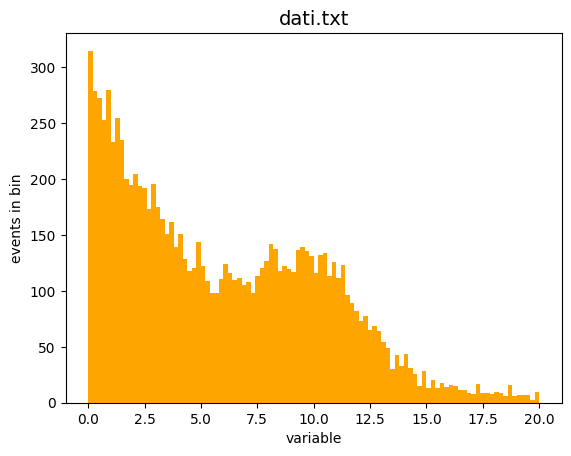

In [1]:
import numpy as np
from math import floor, ceil
from matplotlib import pyplot as plt

# read the file
with open('dati.txt') as f:
    sample = [float (x) for x in f.readlines()]

# show its content in a histogram
sample_mean = np.mean (sample)
sample_sigma = np.std (sample)
# first guess of x_axis range, before looking at the histogram
# x_min = sample_mean - 3 * sample_sigma 
# x_max = sample_mean + 3 * sample_sigma
x_min   = floor (min (sample))
x_max   = ceil (max (sample))
x_range = (x_min, x_max)
N_bins  = floor (len (sample)/100)

# build a numpy histogram containing the data counts in each bin
bin_content, bin_edges = np.histogram (sample, bins = N_bins, range = x_range)

fig, ax = plt.subplots ()
ax.set_title ('dati.txt', size=14)
ax.set_xlabel('variable')
ax.set_ylabel('events in bin')
ax.hist (sample,
         bins = bin_edges,
         color = 'orange',
        )
plt.show ()

### building the fitting model

In [2]:
from iminuit import Minuit
from scipy.stats import expon, norm
from iminuit.cost import ExtendedBinnedNLL

# the fitting function
def mod_total (bin_edges, N_signal, mu, sigma, N_background, tau):
    return N_signal * norm.cdf (bin_edges, mu, sigma) + \
            N_background * expon.cdf (bin_edges, 0, tau)

N_events = sum (bin_content)

# the cost function for the fit
my_cost_func = ExtendedBinnedNLL (bin_content, bin_edges, mod_total)

# the fitting algoritm
my_minuit = Minuit (my_cost_func, 
                    N_signal = N_events, mu = sample_mean, sigma = sample_sigma, # signal input parameters
                    N_background = N_events, tau = 1.)                          # background input parameters

# bounds the following parameters to being positive
my_minuit.limits['N_signal', 'N_background', 'sigma', 'tau'] = (0, None)

### fitting with only the background model
to determine the background parameters to be used as starting point for the final fit

In [3]:
# fixing the following parameters,
# setting the signal to zero for a first background-only preliminary fit
my_minuit.values["N_signal"] = 0
my_minuit.fixed["N_signal", "mu", "sigma"] = True

# we temporarily mask out the signal
bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])
my_cost_func.mask = (bin_centres < 5) | (15 < bin_centres)

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 43.56 (χ²/ndof = 0.9)      │              Nfcn = 142              │
│ EDM = 9.51e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │     0     │   0.1e3   │            │            │    0    │         │  yes  │
│ 1 │ mu           │   5.92    │   0.06    │            │            │         │         │  yes  │
│ 2 │ sigma        │   4.43    │   0.04    │            │            │    0    │         │  yes  │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │       │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            0            0            0            0        0.000 │
│           mu │            0            0            0            0        0.000 │
│        sigma │            0            0            0            0        0.000 │
│ N_background │            0            0            0     1.71e+04        7.192 │
│          tau │        0.000        0.000        0.000        7.192       0.0106 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### fitting with only the signal model
to estimate the signal parameters to be used as starting point for the final fit

In [4]:
my_cost_func.mask = None # remove mask
my_minuit.fixed = False # release all parameters
my_minuit.fixed["N_background", "tau"] = True # fix background amplitude
my_minuit.values["N_signal"] = N_events - my_minuit.values["N_background"] # do not start at the limit

my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 88.68 (χ²/ndof = 0.9)      │              Nfcn = 406              │
│ EDM = 8.41e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.23e3   │  0.07e3   │  -0.07e3   │   0.07e3   │    0    │         │       │
│ 1 │ mu           │   9.99    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.04    │   0.06    │   -0.06    │    0.07    │    0    │         │       │
│ 3 │ N_background │  7.98e3   │  0.13e3   │  -0.13e3   │   0.13e3   │    0    │         │  yes  │
│ 4 │ tau          │    5.2    │    0.1    │    -0.1    │    0.1     │    0    │         │  yes  │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.13e3  │  0.13e3   │   -0.1    │    0.1    │    -70    │    70     │   -0.08   │   0.08    │   -0.06   │   0.07    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │      4.9e+03       -1.390        1.744          0e3          0e3 │
│           mu │       -1.390      0.00572       -0.001        0.000        0.000 │
│        sigma │        1.744       -0.001      0.00421        0.000        0.000 │
│ N_background │          0e3        0.000        0.000            0            0 │
│          tau │          0e3        0.000        0.000            0            0 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### final fit over the full range, with the full model

In [5]:
my_minuit.fixed = False # release all parameters
my_minuit.migrad ()
my_minuit.minos ()
print (my_minuit.valid)
display (my_minuit)

True


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.78 (χ²/ndof = 0.9)      │              Nfcn = 898              │
│ EDM = 5.83e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │     N_background      │          tau          │       N_signal        │          mu           │         sigma         │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.14e3  │  0.14e3   │   -0.11   │   0.11    │  -0.11e3  │  0.11e3   │   -0.08   │   0.08    │   -0.08   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.857        5.921     -0.011e6       -8.275 │
│           mu │       -2.857      0.00621       -0.002        3.034        0.001 │
│        sigma │        5.921       -0.002      0.00681       -6.641       -0.005 │
│ N_background │     -0.011e6        3.034       -6.641     2.01e+04       10.022 │
│          tau │       -8.275        0.001       -0.005       10.022       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘

### The parameter values and uncertainties

In [6]:
print (my_minuit.params)

┌───┬──────────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name         │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N_signal     │  2.31e3   │  0.11e3   │  -0.11e3   │   0.11e3   │    0    │         │       │
│ 1 │ mu           │   9.97    │   0.08    │   -0.08    │    0.08    │         │         │       │
│ 2 │ sigma        │   2.09    │   0.08    │   -0.08    │    0.08    │    0    │         │       │
│ 3 │ N_background │  7.85e3   │  0.14e3   │  -0.14e3   │   0.14e3   │    0    │         │       │
│ 4 │ tau          │   5.11    │   0.11    │   -0.11    │    0.11    │    0    │         │       │
└───┴──────────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [7]:
#print (my_minuit.merrors)
for elem in my_minuit.merrors:
    print (elem + ' : + ' + str (my_minuit.merrors[elem].upper) + ' ' + str (my_minuit.merrors[elem].lower))

N_background : + 141.66775442102366 -142.364219981618
tau : + 0.11391045360413823 -0.1132506900991527
N_signal : + 110.4271242229494 -106.93841130331256
mu : + 0.07828724029088165 -0.07937371073356515
sigma : + 0.08437594658376164 -0.08092110138081635


In [8]:
for key in my_minuit.parameters : # parameters is a tuple containing the parameter names
    print ('parameter ' + key + ': ' + 
           str (my_minuit.values[key]) + ' +- ' + 
           str (my_minuit.errors[key]) + '   |   ' +
           str (my_minuit.merrors[key].upper) + ' ' + 
           str (my_minuit.merrors[key].lower)
          )

parameter N_signal: 2308.1512554581673 +- 108.58035217734141   |   110.4271242229494 -106.93841130331256
parameter mu: 9.97394336750722 +- 0.07878644064750405   |   0.07828724029088165 -0.07937371073356515
parameter sigma: 2.0865308514039067 +- 0.08254069031557365   |   0.08437594658376164 -0.08092110138081635
parameter N_background: 7848.772941008475 +- 141.92667441673666   |   141.66775442102366 -142.364219981618
parameter tau: 5.112032036497856 +- 0.11349561166179578   |   0.11391045360413823 -0.1132506900991527


### Covariance matrix of the parameters

In [9]:
print (my_minuit.covariance)

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │     1.18e+04       -2.857        5.921     -0.011e6       -8.275 │
│           mu │       -2.857      0.00621       -0.002        3.034        0.001 │
│        sigma │        5.921       -0.002      0.00681       -6.641       -0.005 │
│ N_background │     -0.011e6        3.034       -6.641     2.01e+04       10.022 │
│          tau │       -8.275        0.001       -0.005       10.022       0.0129 │
└──────────────┴──────────────────────────────────────────────────────────────────┘


In [10]:
print (my_minuit.covariance[0][1])
print (my_minuit.covariance['N_signal']['N_background'])

-2.8568870609223675
-10688.478687308894


In [11]:
# get the correlation matrix:
print (my_minuit.covariance.correlation ())

┌──────────────┬──────────────────────────────────────────────────────────────────┐
│              │     N_signal           mu        sigma N_background          tau │
├──────────────┼──────────────────────────────────────────────────────────────────┤
│     N_signal │            1         -0.3          0.7         -0.7         -0.7 │
│           mu │         -0.3            1         -0.4          0.3          0.1 │
│        sigma │          0.7         -0.4            1         -0.6         -0.5 │
│ N_background │         -0.7          0.3         -0.6            1          0.6 │
│          tau │         -0.7          0.1         -0.5          0.6            1 │
└──────────────┴──────────────────────────────────────────────────────────────────┘
